# Combine Models From Multiple Runs With Model Averaging Ensemble

Deep learning neural network models are highly flexible nonlinear algorithms capable of learning a nearly infinite number of mapping functions. Frustration with this flexibility is the high variance in a final model. The same neural network model trained on the same dataset may nd one of many different possible good enough solutions each time it is run. In this tutorial, you will discover how to develop a model averaging ensemble in Keras to reduce the variance in a final model. Model averaging is an ensemble learning technique that reduces the variance in a final neural network model, sacrificing spread (and possibly better scores) in the model's performance for confidence in what performance to expect from the model. After completing this tutorial, you will know:

* Model averaging is an ensemble learning technique that can be used to reduce the expected variance of deep learning neural network models.
* How to implement model averaging in Keras for classification and regression predictive modeling problems.
* How to work through a multiclass classification problem and use model averaging to reduce the variance of the final model.

## Model Averaging Ensemble

Deep learning neural network models are nonlinear methods that learn via a stochastic training algorithm. This means that they are highly flexible, capable of learning complex relationships between variables and approximating any mapping function, given enough resources. A downside of this flexibility is that the models suffer high variance. This means that the models are highly dependent on the specific training data used to train the model and on the initial conditions (random initial weights) and serendipity during the training process. The result is a final model that makes different predictions each time the same model configuration is trained on the same dataset.

This can be frustrating when training a final model to make predictions on new data, such as operationally or in a machine learning competition. The high variance of the approach can be addressed by training multiple models for the problem and combining their predictions. This approach is called model averaging and belongs to a family of techniques called ensemble learning.

## Ensembles in Keras

The simplest way to develop a model averaging ensemble in Keras is to train multiple models on the same dataset then combine the predictions from each of the trained models.

### Train Multiple Models

Training multiple models may be resource-intensive, depending on the size of the model and the size of the training data. You may have to train the models sequentially on the same hardware. For very large models, it may be worth training the models in parallel using cloud infrastructure
such as Amazon Web Services.

The number of models required for the ensemble may vary based on the complexity of the problem and model. A benefit of the approach is that you can continue creating models, adding them to the ensemble, and evaluating their impact on the performance by making predictions on a holdout test set. You can train the models sequentially for small models and keep them in memory for use in your experiment. For example:

```
...
# train models and keep them in memory
n_members = 10
models = list()
for _ in range(n_members):
    # define and fit model
    model = ...
    
    # store model in memory as ensemble member
    models.add(models)
...
```

For large models, perhaps trained on different hardware, you can save each model to a file.

```
...
# train models and keep them to file
n_members = 10
for i in range(n_members):
    # define and fit model
    model = ...

    # save model to file
    filename = 'model_' + str(i + 1) + '.h5'
    model.save(filename)
    
    print('Saved: %s' % filename)
...
```

Models can then be loaded later. Small models can all be loaded into memory simultaneously, whereas very large models may have to be loaded one at a time to make a prediction, then later to have the predictions combined.

```
from tensorflow.keras.models import load_model
...

# load pre-trained ensemble members
n_members = 10
models = list()

for i in range(n_members):
    # load model
    filename = 'model_' + str(i + 1) + '.h5'
    model = load_model(filename)

    # store in memory
    models.append(model)
...
```

### Combine Predictions

Once the models have been prepared, each model can be used to predict, and the predictions can be combined. In a regression problem where each model predicts a real-valued output, the values can be collected, and the average is calculated.

```
...
# make predictions
yhats = [model.predict(testX) for model in models]
yhats = array(yhats)

# calculate average
outcomes = mean(yhats)
```

In the case of a classification problem, there are two options: to combine the predicted class labels or to combine the predicted probabilities. The class labels can be combined by calculating the statistical mode (most frequent value), for example:

```
...
# make predictions
yhats = [model.predict_classes(testX) for model in models]
yhats = array(yhats)

# calculate mode
outcomes, _ = mode(yhats)
```

A downside of this approach is that for small ensembles or problems with a large number of classes, the sample of predictions may not be large enough for the mode to be meaningful. A sigmoid activation function is used on the output layer in a binary classification problem, and the average of the predicted probabilities can be calculated much like a regression problem. In the case of a multiclass classification problem with more than two classes, a softmax activation function is used on the output layer, and the sum of the probabilities for each predicted class can be calculated before taking the argmax to get the class value, for example:

```
...
# make predictions
yhats = [model.predict(testX) for model in models]
yhats = array(yhats)

# sum across ensembles
summed = numpy.sum(yhats, axis=0)

# argmax across classes
outcomes = argmax(summed, axis=1)
```

These approaches for combining predictions of Keras models will work just as well for Multilayer Perceptron, Convolutional, and Recurrent Neural Networks. Now that we know how to average predictions from multiple neural network models in Keras, let us work through a case study.

## Model Averaging Ensemble Case Study

In this section, we will demonstrate how to use the model average ensemble to reduce the variance of an MLP on a simple multiclass classification problem. This example provides a template for applying the model average ensemble to your neural network for classification and regression problems.

### Multiclass Classification Problem

We will use a small multiclass classification problem as the basis to demonstrate a model averaging ensemble. The scikit-learn class provides the `make_blobs()` function that can be used to create a multiclass classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We use this problem with 500 examples, with two input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group. We will use the same random state (seed for the pseudorandom number generator) to ensure that we always get the same 500 points.

In [1]:
from sklearn.datasets import make_blobs

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

The results are the input and output elements of a dataset that we can model. In order to get a feeling for the complexity of the problem, we can graph each point on a two-dimensional scatter plot and color each point by class value. The complete example is listed below.

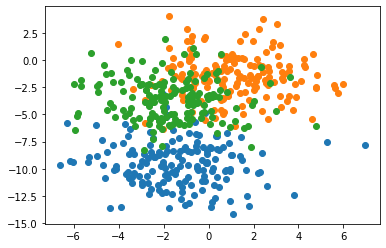

In [2]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)

    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (separable by a line), causing many ambiguous points. This is desirable because the problem is non-trivial and will allow a neural network model to find many different *good enough* candidate solutions resulting in a high variance.

### MLP Model for Multiclass Classification

Now that we have defined a problem, we can define a model to address it. We will define a model that is perhaps under-constrained and not tuned to the problem. This is intentional to demonstrate the high variance of a neural network model seen on truly large and challenging supervised learning problems. 

The problem is a multiclass classification problem, and we will model it using a softmax activation function on the output layer. This means that the model will predict a vector with three elements with the probability that the sample belongs to each of the three classes. Therefore, the first step is to one-hot encode the class values.

In [3]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y)

Next, we must split the dataset into training and test sets. We will use the test set both to evaluate the model's performance and to plot its performance during training with a learning curve. We will use 30% of the data for training and 70% for the test set. This is an example of a challenging problem where we have more unlabeled examples than labeled ones.

In [4]:
# split into train and test
n_train = int(0.3 * X.shape[0])

trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

Next, we can define and compile the model. The model will expect samples with two input variables. The model then has a single hidden layer with 15 nodes and a rectified linear activation function, an output layer with three nodes to predict the probability of each of the three classes, and a softmax activation function. Because the problem is multiclass, we will use the categorical cross-entropy loss function to optimize the model and the efficient Adam flavor of stochastic gradient descent.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(15, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The model is fit for 200 training epochs, and we will evaluate each epoch on the test set, using the test set as a validation set.

In [6]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=1)

Epoch 1/200
5/5 [==============================] - 2s 76ms/step - loss: 1.4741 - accuracy: 0.4318 - val_loss: 1.6042 - val_accuracy: 0.3371
Epoch 2/200
5/5 [==============================] - 0s 8ms/step - loss: 1.4272 - accuracy: 0.4144 - val_loss: 1.5493 - val_accuracy: 0.3371
Epoch 3/200
5/5 [==============================] - 0s 8ms/step - loss: 1.3817 - accuracy: 0.4465 - val_loss: 1.4973 - val_accuracy: 0.3400
Epoch 4/200
5/5 [==============================] - 0s 8ms/step - loss: 1.2633 - accuracy: 0.4705 - val_loss: 1.4479 - val_accuracy: 0.3343
Epoch 5/200
5/5 [==============================] - 0s 8ms/step - loss: 1.3297 - accuracy: 0.4193 - val_loss: 1.4011 - val_accuracy: 0.3429
Epoch 6/200
5/5 [==============================] - 0s 8ms/step - loss: 1.1513 - accuracy: 0.4627 - val_loss: 1.3580 - val_accuracy: 0.3543
Epoch 7/200
5/5 [==============================] - 0s 8ms/step - loss: 1.1475 - accuracy: 0.4798 - val_loss: 1.3178 - val_accuracy: 0.3629
Epoch 8/200
5/5 [=========

5/5 [==============================] - 0s 8ms/step - loss: 0.6058 - accuracy: 0.6904 - val_loss: 0.7750 - val_accuracy: 0.6400
Epoch 60/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5672 - accuracy: 0.7216 - val_loss: 0.7710 - val_accuracy: 0.6429
Epoch 61/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5467 - accuracy: 0.6956 - val_loss: 0.7676 - val_accuracy: 0.6486
Epoch 62/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5629 - accuracy: 0.6891 - val_loss: 0.7641 - val_accuracy: 0.6486
Epoch 63/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5748 - accuracy: 0.7003 - val_loss: 0.7610 - val_accuracy: 0.6600
Epoch 64/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5199 - accuracy: 0.7269 - val_loss: 0.7585 - val_accuracy: 0.6600
Epoch 65/200
5/5 [==============================] - 0s 8ms/step - loss: 0.5037 - accuracy: 0.7313 - val_loss: 0.7557 - val_accuracy: 0.6714
Epoch 66/200
5/5 [===============

5/5 [==============================] - 0s 8ms/step - loss: 0.4621 - accuracy: 0.7277 - val_loss: 0.6862 - val_accuracy: 0.7029
Epoch 118/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4600 - accuracy: 0.7320 - val_loss: 0.6853 - val_accuracy: 0.7029
Epoch 119/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4365 - accuracy: 0.7915 - val_loss: 0.6842 - val_accuracy: 0.7029
Epoch 120/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4380 - accuracy: 0.7585 - val_loss: 0.6830 - val_accuracy: 0.7029
Epoch 121/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4588 - accuracy: 0.7598 - val_loss: 0.6822 - val_accuracy: 0.7057
Epoch 122/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4771 - accuracy: 0.7225 - val_loss: 0.6814 - val_accuracy: 0.7057
Epoch 123/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4295 - accuracy: 0.7720 - val_loss: 0.6809 - val_accuracy: 0.7057
Epoch 124/200
5/5 [========

5/5 [==============================] - 0s 8ms/step - loss: 0.4040 - accuracy: 0.8036 - val_loss: 0.6483 - val_accuracy: 0.7286
Epoch 176/200
5/5 [==============================] - 0s 9ms/step - loss: 0.4155 - accuracy: 0.7941 - val_loss: 0.6478 - val_accuracy: 0.7286
Epoch 177/200
5/5 [==============================] - 0s 9ms/step - loss: 0.3967 - accuracy: 0.7919 - val_loss: 0.6473 - val_accuracy: 0.7286
Epoch 178/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4118 - accuracy: 0.8219 - val_loss: 0.6467 - val_accuracy: 0.7286
Epoch 179/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4160 - accuracy: 0.8040 - val_loss: 0.6462 - val_accuracy: 0.7286
Epoch 180/200
5/5 [==============================] - 0s 9ms/step - loss: 0.4075 - accuracy: 0.8132 - val_loss: 0.6452 - val_accuracy: 0.7286
Epoch 181/200
5/5 [==============================] - 0s 8ms/step - loss: 0.4079 - accuracy: 0.8106 - val_loss: 0.6440 - val_accuracy: 0.7314
Epoch 182/200
5/5 [========

At the end of the run, we will evaluate the model's performance on both the train and the test sets.

In [7]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.820, Test: 0.737


Then finally, we will plot model loss and accuracy learning curves over each training epoch on both the training and test dataset.

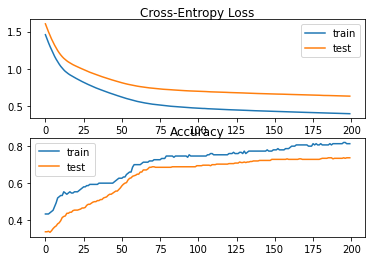

In [8]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

The complete example is listed below.

In [9]:
# fit high variance mlp on blobs classification problem
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(15, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.847, Test: 0.771


Running the example, it first prints the performance of the final model on the train and test datasets.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the model achieved about 84% accuracy on the training dataset and 76 % accuracy on the test dataset, which is not terrible.

A line plot also shows the learning curves for the model accuracy on the train and test sets over each training epoch. We can see that the model is not really overfitting but is perhaps a little underfit and may benefit from an increase in capacity, more training, and perhaps some regularization. We intentionally hold back all of these improvements to force high variance for our case study.

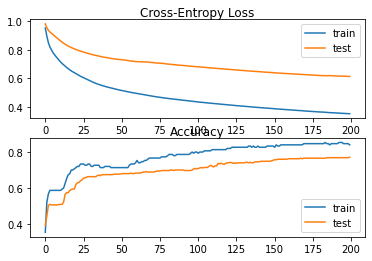

In [10]:
# plot loss learning curves
pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss', pad=-40)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy', pad=-40)
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

pyplot.show()

### High Variance of MLP Model

It is important to demonstrate that the model indeed has a variance in its prediction. We can demonstrate this by repeating the fit and evaluation of the same model configuration on the same dataset and summarizing the final performance of the model. To do this, we first split the fit and evaluation of the model out as a function that we can call repeatedly. The `evaluate_model()` function below takes the train, and the test dataset fits a model, then evaluates it, retuning the model's accuracy on the test dataset.

In [28]:
# fit and evaluate a neural net model on the dataset
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    model = Sequential()
    model.add(Dense(15, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy, epochs=200, verbose=0)

    # evaluate the model
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    
    return test_acc

We can call this function 30 times, saving the test accuracy scores.

In [29]:
# repeated evaluation
n_repeats = 30
scores = list()
for _ in range(n_repeats):
    score = evaluate_model(trainX, trainy, testX, testy)
    print('> %.3f' % score)
    scores.append(score)

> 0.791
> 0.786
> 0.777
> 0.740
> 0.809
> 0.771
> 0.763
> 0.749
> 0.751
> 0.723
> 0.740
> 0.771
> 0.794
> 0.771
> 0.811
> 0.789
> 0.803
> 0.769
> 0.786
> 0.769
> 0.780
> 0.723
> 0.763
> 0.786
> 0.743
> 0.809
> 0.814
> 0.737
> 0.774
> 0.766


Once collected, we can summarize the distribution scores, first in terms of the mean and standard deviation, assuming the distribution is Gaussian, which is very reasonable.

In [31]:
from numpy import mean
from numpy import std

# summarize the distribution of scores
print('Scores Mean: %.3f, Standard Deviation: %.3f' % (mean(scores), std(scores)))

Scores Mean: 0.772, Standard Deviation: 0.025


We can then summarize the distribution both as a histogram to show the shape of the distribution and as a box and whisker plot to show the spread and body of the distribution.

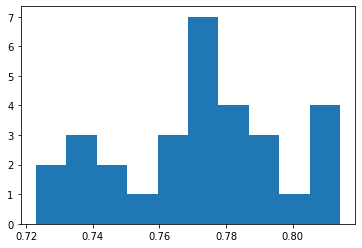

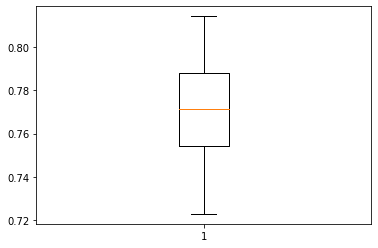

In [32]:
# histogram of distribution
pyplot.hist(scores, bins=10)
pyplot.show()

# boxplot of distribution
pyplot.boxplot(scores)
pyplot.show()

The complete example of summarizing the variance of the MLP model on the chosen blobs dataset is listed below.

In [34]:
# demonstrate high variance of mlp model on blobs classification problem
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from numpy import mean, std
from matplotlib import pyplot

# fit and evaluate a neural net model on the dataset
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    model = Sequential()
    model.add(Dense(15, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy, epochs=200, verbose=0)

    # evaluate the model
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    
    return test_acc

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# repeated evaluation
n_repeats = 30
scores = list()
for _ in range(n_repeats):
    score = evaluate_model(trainX, trainy, testX, testy)
    print('> %.3f' % score)
    scores.append(score)

# summarize the distribution of scores
print('Scores Mean: %.3f, Standard Deviation: %.3f' % (mean(scores), std(scores)))

> 0.757
> 0.763
> 0.757
> 0.786
> 0.754
> 0.791
> 0.783
> 0.757
> 0.769
> 0.766
> 0.794
> 0.791
> 0.777
> 0.769
> 0.783
> 0.774
> 0.737
> 0.766
> 0.714
> 0.760
> 0.766
> 0.789
> 0.780
> 0.797
> 0.760
> 0.754
> 0.791
> 0.791
> 0.760
> 0.740
Scores Mean: 0.769, Standard Deviation: 0.019


Running the example first prints the accuracy of each model on the test set, finishing with the mean and standard deviation of the sample of accuracy scores.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the average of the sample is 76.9%, with a standard deviation of about 1.9%. Assuming a Gaussian distribution, we would expect 99% of accuracy scores to fall between about 73% and 81% (i.e., three standard deviations above and below the mean). We can take the standard deviation of the model's accuracy on the test set as an estimate for the variance of the predictions made by the model.

A histogram of the accuracy scores is also created, showing a very rough Gaussian shape, perhaps with a longer right tail. A large sample and a different number of bins on the plot might better expose the true underlying shape of the distribution.

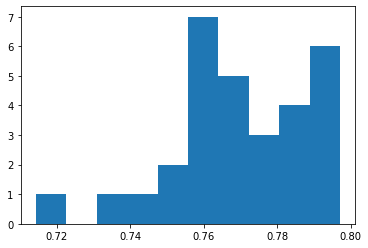

In [35]:
# histogram of distribution
pyplot.hist(scores, bins=10)
pyplot.show()

A box and whisker plot is also created, showing a line at the median at about 76.5% accuracy on the test set and the interquartile range or middle 50% of the samples between about 78% and 76%.

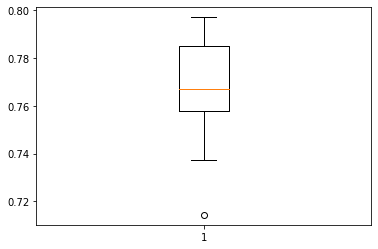

In [36]:
# boxplot of distribution
pyplot.boxplot(scores)
pyplot.show()

The analysis of the sample of test scores demonstrates a variance in the performance of the same model trained on the same dataset. A spread of likely scores of about eight percentage points (81% to 73%) on the test set could reasonably be considered large, e.g., a high variance result.

### Model Averaging Ensemble

We can use model averaging to reduce the variance of the model and possibly reduce the model's generalization error. Specifically, this would result in a smaller standard deviation on the holdout test set and better performance on the training set. We can check both of these assumptions. First, we must develop a function to prepare and return a fit model on the training dataset.

In [37]:
# fit model on dataset
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(15, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy, epochs=200, verbose=0)

    return model

Next, we need a function to take a list of ensemble members and predict an out-of-sample dataset. This could be one or more samples arranged in a two-dimensional array of samples and input features. Tip: you can use this function yourself to test ensembles and make predictions with ensembles on new data.

In [38]:
# make an ensemble prediction for multiclass classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)

    # argmax across classes
    result = argmax(summed, axis=1)

    return result

We do not know how many ensemble members will be appropriate for this problem. Therefore, we can perform a sensitivity analysis of the number of ensemble members and how it impacts test accuracy. This means we need a function that can evaluate a specified number of ensemble members and return the accuracy of a prediction combined from those members.

In [39]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]
    print(len(subset))

    # make prediction
    yhat = ensemble_predictions(subset, testX)
    
    # calculate accuracy
    return accuracy_score(testy, yhat)

Finally, we can create a line plot of the number of ensemble members (x-axis) versus the prediction accuracy averaged across that many members on the test dataset (y-axis).

```
# plot score vs number of ensemble members
x_axis = [i for i in range(1, n_members+1)]
pyplot.plot(x_axis, scores)
pyplot.show()
```

The complete example is listed below.

In [41]:
# model averaging ensemble and a study of ensemble size on test accuracy
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from numpy import array, argmax
import numpy

# fit model on dataset
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(15, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy, epochs=200, verbose=0)

    return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)

    # argmax across classes
    result = argmax(summed, axis=1)

    return result

# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    # select a subset of members
    subset = members[:n_members]

    print(len(subset))
    # make prediction
    yhat = ensemble_predictions(subset, testX)

    # calculate accuracy
    return accuracy_score(testy, yhat)

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
trainy = to_categorical(trainy)

# fit all models
n_members = 20
members = [fit_model(trainX, trainy) for _ in range(n_members)]

# evaluate different numbers of ensembles
scores = list()
for i in range(1, n_members+1):
    score = evaluate_n_members(members, i, testX, testy)
    print('> %.3f' % score)
    scores.append(score)

1
> 0.763
2
> 0.769
3
> 0.769
4
> 0.777
5
> 0.769
6
> 0.774
7
> 0.774
8
> 0.774
9
> 0.774
10
> 0.774
11
> 0.774
12
> 0.774
13
> 0.774
14
> 0.774
15
> 0.774
16
> 0.774
17
> 0.777
18
> 0.771
19
> 0.771
20
> 0.771


Running the example first fits 20 models on the same training dataset, which may take less than a minute on modern hardware. Then, different-sized ensembles are tested from 1 to all 20 members, and test accuracy results are printed for each ensemble size.

Finally, a line plot shows the relationship between ensemble size and performance on the test set. We can see that performance improves to about five members, after which performance plateaus around 77% accuracy. This is close to the average test set performance observed during the analysis of the repeated evaluation of the model.

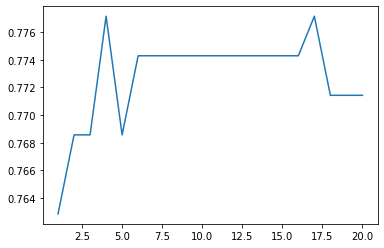

In [42]:
# plot score vs number of ensemble members
x_axis = [i for i in range(1, n_members+1)]
pyplot.plot(x_axis, scores)
pyplot.show()

Finally, we can update the repeated evaluation experiment to use an ensemble of five models instead of a single model and compare the distribution of scores. The complete example of a repeated evaluated five-member ensemble of the blobs dataset is listed below.

In [44]:
# repeated evaluation of model averaging ensemble on blobs dataset
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from numpy import array, argmax
import numpy

# fit model on dataset
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(15, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit model
    model.fit(trainX, trainy, epochs=200, verbose=0)

    return model

# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)

    # sum across ensemble members
    summed = numpy.sum(yhats, axis=0)

    # argmax across classes
    result = argmax(summed, axis=1)

    return result

# evaluate ensemble model
def evaluate_members(members, testX, testy):
    # make prediction
    yhat = ensemble_predictions(members, testX)
    
    # calculate accuracy
    return accuracy_score(testy, yhat)

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
trainy = to_categorical(trainy)

# repeated evaluation
n_repeats = 30
n_members = 5
scores = list()

for _ in range(n_repeats):
    # fit all models
    members = [fit_model(trainX, trainy) for _ in range(n_members)]

    # evaluate ensemble
    score = evaluate_members(members, testX, testy)
    print('> %.3f' % score)
    scores.append(score)

# summarize the distribution of scores
print('Scores Mean: %.3f, Standard Deviation: %.3f' % (mean(scores), std(scores)))

> 0.771
> 0.766
> 0.763
> 0.771
> 0.754
> 0.760
> 0.769
> 0.774
> 0.766
> 0.760
> 0.760
> 0.766
> 0.769
> 0.763
> 0.771
> 0.771
> 0.763
> 0.760
> 0.771
> 0.769
> 0.771
> 0.769
> 0.769
> 0.771
> 0.774
> 0.769
> 0.769
> 0.766
> 0.769
> 0.771
Scores Mean: 0.767, Standard Deviation: 0.005


Running the example may take a few minutes as five models are fit and evaluated, and this process is repeated 30 times. The performance of each model on the test set is printed to provide an indication of progress. The mean and standard deviation of the model performance is printed
at the end of the run.

**Note:** Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that the average performance of a five-member ensemble on the dataset is 76.7%. This is very close to the average of 77% seen for a single model. The important difference is the standard deviation shrinking from 1.9% for a single model to 0.5% with an ensemble of five models. We might expect that a given ensemble of five models on this problem to have a performance fall between about 74% and about 78%, with a likelihood of 99%.

Averaging the same model trained on the same dataset gives us a spread for improved reliability, a property often highly desired in a final model to be used operationally. More models in the ensemble will further decrease the standard deviation of the accuracy of an ensemble on the test dataset given the law of large numbers, at least to the point of diminishing returns. This demonstrates that for this specific model and prediction problem, that a model averaging ensemble with five members is sufficient to reduce the variance of the model. This reduction in variance, in turn, also means a better on-average performance when preparing a final model.

## Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.

* **Average Class Prediction**. Update the example to average the class integer prediction instead of the class probability prediction and compare results.
* **Save and Load Models**. Update the example to save ensemble members to a file, then load them from a separate script for evaluation.
* **Sensitivity of Variance**. Create a new example that performs a sensitivity analysis of the number of ensemble members on the standard deviation of model performance on the test set over a given number of repeats and report the point of diminishing returns.

## Summary

In this tutorial, you discovered how to develop a model averaging ensemble in Keras to reduce the variance in a final model. Specifically, you learned:

* Model averaging is an ensemble learning technique that can be used to reduce the expected variance of deep learning neural network models.
* How to implement model averaging in Keras for classification and regression predictive modeling problems.
* How to work through a multiclass classification problem and use model averaging to reduce the variance of the final model.